In [1]:
from itertools import product, permutations, combinations
from functools import reduce
import numpy as np
import qutip as q
import scipy.constants as c

from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator, Pauli

from src import *

In [2]:
import matplotlib.pyplot as plt

# plt.style.use("seaborn-v0_8")
plt.rcParams.update(
    {
        # "text.usetex": True,
        # "font.family": "serif",
        # "font.serif": ["Times"], # used in elsarticle (Elsevier)
        # "font.serif": ["Computer Modern Roman"], # used in revtex4-2 (APS)
        # "text.latex.preamble": r"\usepackage{amsmath}\usepackage{siunitx}",
        "legend.fontsize": 20,
        "xtick.labelsize": 20,
        "ytick.labelsize": 20,
        "axes.labelsize": 20,
        "axes.titlesize": 20,
        "font.size": 20,
    }
)

In [3]:
# gg1: add position of one C13 in register
# gg2: add position of two C13 in register

# gCCE2: not for C13, for P1 only for two P1 centers that are closer than 55nm

# more than 2nm > unwanted since hard to control
# Bell 0.02, Bell 0.05, GHZ 0.02, GHZ 0.05 (800 spin bath states, >0.99, gCCE1)
# impact radius 4nm (Bell), 5nm(GHZ)
# Bell (200 spin bath states, >0.94, gCCE2)
# impact radius
# P1: >30nm, 200ppb, 9 impurities, impact radius

## Rest

In [7]:
# Fig. 3 in Dominik's paper (binomial distribution)

def calc_num_C(volume):
    """ Calculates the number of C-12 and C-13 atoms in a given volume. """
    a_C = 3.567e-10 # lattice constant for carbon
    V_unit = a_C**3 # volume of the unit cell
    N_unit = 8 # number of carbon atoms per unit cell
    V = volume
    N = V * N_unit/V_unit # number of carbon atoms inside the sphere
    return N

def calc_num_C13(volume, abundancy):
    """ Calculates the number of C-13 atoms in a given volume. Equals the expectation value of the binomial distribution. """
    N = calc_num_C(volume)
    return int(abundancy * N)

def calc_num_P1(volume, abundancy):
    """ Calculates the number of P1 centers in a given volume. Equals the expectation value of the binomial distribution. """
    return calc_num_C13(volume, abundancy)

volume = 4/3 * np.pi * (1.8e-9)**3 # volume of a sphere with radius 1.8nm
N = calc_num_C(volume) # number of carbon atoms in the volume

# Binomial distribution: abundancy is probability of finding a C-13 instead of a C-12
abundancies = np.arange(2, 11) * 0.005e-2
more_than_zero, more_than_one, more_than_two = [], [], []
for abundancy in abundancies: 
    zero_C13 = (1-abundancy)**N
    one_C13 = N * abundancy * (1-abundancy)**(N-1)
    two_C13 = N*(N-1)/2 * abundancy**2 * (1-abundancy)**(N-2)
    more_than_zero.append( 1- zero_C13 )
    more_than_one.append( 1- zero_C13 - one_C13 )
    more_than_two.append( 1- zero_C13 - one_C13 - two_C13 )

In [8]:
# Fig. 3 in Dominik's paper (sampling over random realizations of spin baths)

def get_spin_bath_pos(num_bath_spins, rmin=0, rmax=10e-9, seed=123):
    """ Returns random positions of C-13 atoms in sperical coordinates with a given volume. """
    np.random.seed(seed)
    r = np.random.uniform(rmin**3, rmax**3, num_bath_spins)**(1/3)
    theta = np.random.uniform(0, np.pi, num_bath_spins)
    phi = np.random.uniform(0, 2 * np.pi, num_bath_spins)
    return np.array([r, theta, phi]).T

V = 4/3 * np.pi * (10e-9)**3 # volume of a sphere with radius 10m 

num_bath_states = 20000
more_than_one, more_than_two = [], []
abundancies = np.arange(2, 11) * 0.005e-2

for abundancy in abundancies:
    num_C13 = calc_num_C13(volume, abundancy) # expectation value
    num_more_than_one, num_more_than_two = 0, 0
    # sampling over bath states
    for i in range(num_bath_states):
        spin_bath_pos = get_spin_bath_pos(num_C13, seed=i)
        num_close_C13 = int(sum( spin_bath_pos[:,0] <= 1.8e-9 ))
        if num_close_C13 > 1:
            num_more_than_one += 1
        if num_close_C13 > 2:
            num_more_than_two += 1

    more_than_one.append( num_more_than_one/num_bath_states )
    more_than_two.append( num_more_than_two/num_bath_states )

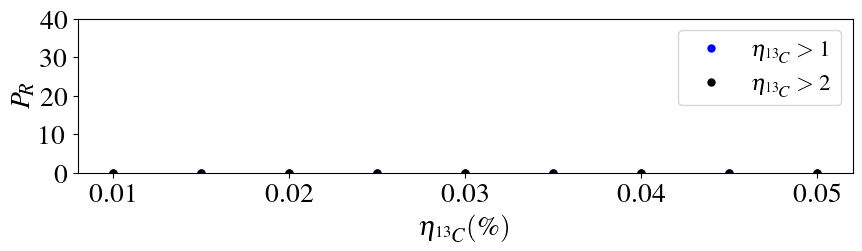

In [9]:
fig, ax = plt.subplots(figsize=(10,2))
ax.plot(abundancies, more_than_one, 'b.', markersize=10, label=r'$\eta_{^{13}C}>1$')
ax.plot(abundancies, more_than_two, 'k.', markersize=10, label=r'$\eta_{^{13}C}>2$')
ax.set_ylabel(r'$P_R$')
ax.set_xlabel(r'$\eta_{^{13}C} (\%)$')
ax.set_ylim(0, 0.4)
# ax.set_xlim(0.01e-2, 0.05e-2)
ax.legend(fontsize='small')
ax.set_xticks([0.01e-2, 0.02e-2, 0.03e-2, 0.04e-2, 0.05e-2], [0.01, 0.02, 0.03, 0.04, 0.05])
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4], [0, 10, 20, 30, 40])
plt.show()

In [10]:
register_radius = 2e-9
for impact_radius, abundancy in [(4e-9, 0.02e-2), (4e-9, 0.05e-2), (5e-9, 0.02e-2), (5e-9, 0.05e-2)]:
    volume = 4/3 * np.pi * (impact_radius**3 - register_radius**3)
    num_C13 = calc_num_C13(volume, abundancy)
    print(f"Impact Radius {impact_radius}, Abundancy {abundancy}: {num_C13} C13 atoms")

Impact Radius 4e-09, Abundancy 0.0002: 8 C13 atoms
Impact Radius 4e-09, Abundancy 0.0005: 20 C13 atoms
Impact Radius 5e-09, Abundancy 0.0002: 17 C13 atoms
Impact Radius 5e-09, Abundancy 0.0005: 43 C13 atoms


In [59]:
volume = 4/3 * np.pi * (35e-9**3 - 2e-9**3)
abundancy = 200e-9

calc_num_P1(volume, abundancy)

6

In [79]:
# C-13 spin bath in Sec. IV. A. 
rmin, rmax = 2e-9, 4.2e-9
abundancy = 0.02e-2

volume = 4/3 * np.pi * (rmax**3 - rmin**3)
num_C13 = calc_num_C13(volume, abundancy)
get_spin_bath_pos(num_C13, rmin=rmin, rmax=rmax, seed=123)
# all possible bath states (2**9 = 512)

array([[3.78042229e-09, 1.23187351e+00, 3.33983578e+00],
       [2.99667693e-09, 1.07812553e+00, 3.34157128e+00],
       [2.84354377e-09, 2.29037720e+00, 3.98605878e+00],
       [3.54195202e-09, 1.37781534e+00, 5.33713737e+00],
       [3.81554723e-09, 1.87483642e-01, 4.55188705e+00],
       [3.30077300e-09, 1.25049291e+00, 3.83917394e+00],
       [4.17583906e-09, 2.31848095e+00, 4.53924565e+00],
       [3.76239520e-09, 5.73314680e-01, 2.02921070e+00],
       [3.41377993e-09, 5.51197948e-01, 2.27318517e+00]])

In [77]:
# P1 spin bath in Sec. IV. A. 
rmin, rmax = 30e-9, 80e-9
abundancy = 26e-9

volume = 4/3 * np.pi * (rmax**3 - rmin**3)
num_P1 = calc_num_P1(volume, abundancy)
num_P1
get_spin_bath_pos(num_P1, rmin=rmin, rmax=rmax, seed=123)
# 1050 bath states (in total there are 12**9 possible bath states, i.e. more than 5 billion)

array([[7.14518270e-08, 1.23187351e+00, 3.33983578e+00],
       [5.49340894e-08, 1.07812553e+00, 3.34157128e+00],
       [5.15542464e-08, 2.29037720e+00, 3.98605878e+00],
       [6.65232107e-08, 1.37781534e+00, 5.33713737e+00],
       [7.21728390e-08, 1.87483642e-01, 4.55188705e+00],
       [6.14645737e-08, 1.25049291e+00, 3.83917394e+00],
       [7.95111141e-08, 2.31848095e+00, 4.53924565e+00],
       [7.10813340e-08, 5.73314680e-01, 2.02921070e+00],
       [6.38456545e-08, 5.51197948e-01, 2.27318517e+00]])

In [ ]:
# P1 spin bath in Sec. IV. B. 
rmin, rmax = 30e-9, 80e-9
abundancy = 200e-9 # 300e-9, 400e-9

volume = 4/3 * np.pi * (rmax**3 - rmin**3)
num_P1 = calc_num_P1(volume, abundancy)
num_P1
get_spin_bath_pos(num_P1, rmin=rmin, rmax=rmax, seed=123)
# 1050 bath states (in total there are 12**9 possible bath states, i.e. more than 5 billion)

# Register

In [53]:
class Evaluation:
    def __init__(self, pulses, target_type):
        self.pulses = pulses
        self.register = self.pulses.register
        self.target_type = target_type
        self.num_spins = self.pulses.register.num_spins

        # time evolution
        self.sim_time = np.linspace(0, 40e-6, 400)
        self.time_evolution = [self.pulses.get_intermediate_state(t) for t in self.sim_time]

        # target state
        if self.num_spins == 2 and self.target_type == 'Bell':
            self.target_state =  1/np.sqrt(2) * (q.tensor(q.basis(2,0), q.basis(2,0)) + q.tensor(q.basis(2,1), q.basis(2,1)) )

        if self.num_spins == 4 and self.target_type == 'Bell':
            self.target_state = 1/np.sqrt(2) * ( q.tensor(q.basis(2,0), q.basis(2,0), q.basis(2,0), q.basis(2,0)) + q.tensor(q.basis(2,0), q.basis(2,1), q.basis(2,1), q.basis(2,0)) )

        if self.num_spins == 4 and self.target_type == 'GHZ':
            self.target_state = 1/np.sqrt(2) * ( q.tensor(q.basis(2,0), q.basis(2,0), q.basis(2,0), q.basis(2,0)) + q.tensor(q.basis(2,0), q.basis(2,1), q.basis(2,1), q.basis(2,1)) )

        self.target_dm = self.target_state * self.target_state.dag()

        # target properties
        if self.num_spins == 2:
            self.target_logarithmic_negativity = calc_logarithmic_negativity(self.target_dm)
        self.Sx_target = q.expect( self.target_dm, self.pulses.register.S_NV_eff_big[1] )
        self.Sy_target = q.expect( self.target_dm, self.pulses.register.S_NV_eff_big[2] )
        self.Sz_target = q.expect( self.target_dm, self.pulses.register.S_NV_eff_big[3] )

    def calc_process_fidelity(self):
        final_state = self.pulses.get_final_state()
        target_state = self.target_dm
        return calc_fidelity(final_state, target_state)

    def calc_process_infidelity(self):
        return 1 - self.calc_process_fidelity()

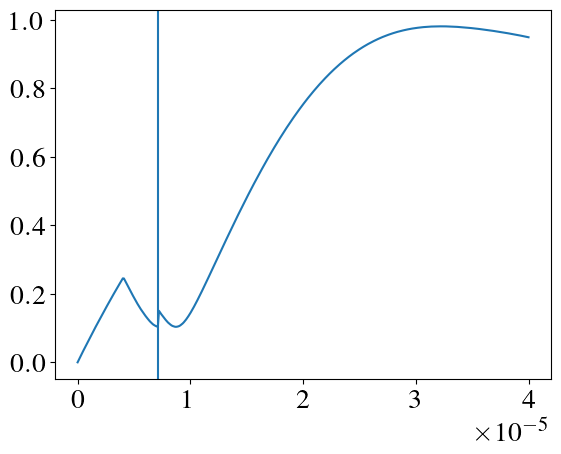

In [596]:
pos_C13 = [(0.87e-9, 0, 0.19e-9)]#, (0.56e-9, 0.77e-9, 0.31e-9), (-0.83e-9, 1.15e-9, 0.46e-9)]
pulse_seq = [0e-6, 4.06e-6, 1.57e-6, 1.51e-6, 1.00, 3.58, 1.68, 0.69, 1.97, 0.50]
target_type = 'Bell'

register = Register(pos_C13)
pulses = Pulses(register, pulse_seq)
evaluation = Evaluation(pulses, target_type)

fig, ax = plt.subplots()
# ax.plot( evaluation.sim_time, [q.expect(rho, register.S_NV_eff_big[3]) for rho in evaluation.time_evolution] )
# ax.plot( evaluation.sim_time, [q.expect(rho, register.S_C13_big[0][1]) for rho in evaluation.time_evolution] )
ax.plot( evaluation.sim_time, [calc_logarithmic_negativity(rho) for rho in evaluation.time_evolution] )
ax.axvline(x=pulses.pulse_time)
plt.show()

# Quantum Computer 

In [2]:
qc = QuantumCircuit(2)

def get_coupling_gate(coupling_type):
    """
    Returns Two-qubit coupling gates
    Coupling types: 'XX', 'YY', 'ZZ', 'XY', 'YX', 'XZ', 'ZX', 'YZ', 'ZY'
    """
    circ = QuantumCircuit(2)
    circ.cx(1,0)
    circ.rz(np.pi, 0)
    circ.cx(1,0)
    zz_gate = circ.to_gate()

    qc = QuantumCircuit(2)
    if coupling_type.upper() == 'ZZ':     
        qc.append(zz_gate, [0,1])

    if coupling_type.upper() == 'YY':     
        qc.rx(np.pi/2, 0)
        qc.rx(np.pi/2, 1)
        qc.append(zz_gate, [0,1])
        qc.rx(-np.pi/2, 0)
        qc.rx(-np.pi/2, 1)

    if coupling_type.upper() == 'XX':     
        qc.h(0)        
        qc.h(1)
        qc.append(zz_gate, [0,1])
        qc.h(0)
        qc.h(1)
    
    if coupling_type.upper() == 'XZ':     
        qc.h(1)
        qc.append(zz_gate, [0,1])
        qc.h(1)

    if coupling_type.upper() == 'ZX':     
        qc.h(0)
        qc.append(zz_gate, [0,1])
        qc.h(0)

    if coupling_type.upper() == 'XY':     
        qc.h(1)
        qc.rx(np.pi/2, 0)
        qc.append(zz_gate, [0,1])
        qc.rx(-np.pi/2, 0)
        qc.h(1)

    if coupling_type.upper() == 'YX':     
        qc.h(0)
        qc.rx(np.pi/2, 1)
        qc.append(zz_gate, [0,1])
        qc.rx(-np.pi/2, 1)
        qc.h(0)

    if coupling_type.upper() == 'YZ':     
        qc.rx(np.pi/2, 1)
        qc.append(zz_gate, [0,1])
        qc.rx(-np.pi/2, 1)

    if coupling_type.upper() == 'ZY':     
        qc.rx(np.pi/2, 0)
        qc.append(zz_gate, [0,1])
        qc.rx(-np.pi/2, 0)

    return qc.to_gate(label=coupling_type)

def check_coupling_gates():
    coupling_types = ['XX', 'YY', 'ZZ', 'XY', 'YX', 'XZ', 'ZX', 'YZ', 'ZY']
    check_list = {}
    for coupling_type in coupling_types:
        qc = QuantumCircuit(2)
        qc.append(get_coupling_gate(coupling_type), [0,1])
        qc_matrix = Operator(qc).to_matrix()
        matrix = Pauli(coupling_type).to_matrix()
        check_list[coupling_type] = np.allclose(1j*qc_matrix, matrix)
    return check_list
    
check_coupling_gates()

{'XX': True,
 'YY': True,
 'ZZ': True,
 'XY': True,
 'YX': True,
 'XZ': True,
 'ZX': True,
 'YZ': True,
 'ZY': True}